Following https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

This is my own data as on [hackster](https://www.hackster.io/robin-cole/motion-activated-image-capture-and-classification-of-birds-6ef1ce) where my previous model had 92% accuracy

Trainng on floydhub GPU

In [15]:
import os
import re
from pathlib import Path
from fastai.vision.data import (get_image_files, ImageDataBunch, imagenet_stats, create_cnn, ClassificationInterpretation)
from fastai.vision.transform import get_transforms
from fastai.metrics import error_rate
from torchvision.models import resnet34
bs = 64

from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.5
fastai        : 1.0.39
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.54
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.4.0-1049-aws-x86_64-with-debian-stretch-sid
distro        : #58-Ubuntu SMP Fri Jan 12 23:17:09 UTC 2018
conda env     : Unknown
python        : /usr/local/bin/python
sys.path      : /usr/local/lib/python36.zip
/usr/local/lib/python3.6
/usr/local/lib/python3.6/lib-dynload

/usr/local/lib/python3.6/site-packages
/usr/local/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg
/usr/local/lib/python3.6/site-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be insta

In [2]:
data_dir = '/floyd/home/data/birds_vs_not_birds'

In [3]:
path_img = Path(data_dir)

In [4]:
fnames = get_image_files(path_img, recurse=True); len(fnames)

1015

Helper to extract class label

In [5]:
def get_labels(file_path : Path):
    """
    Helper to get directory label.
    """
    file_path = str(file_path)
    pattern = re.split('/', file_path)[-2]
    match = re.search(pattern, file_path)
    return match.group()

In [6]:
get_labels(fnames[0])

'not_birds'

In [7]:
data = ImageDataBunch.from_name_func(path_img, fnames, label_func=get_labels, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

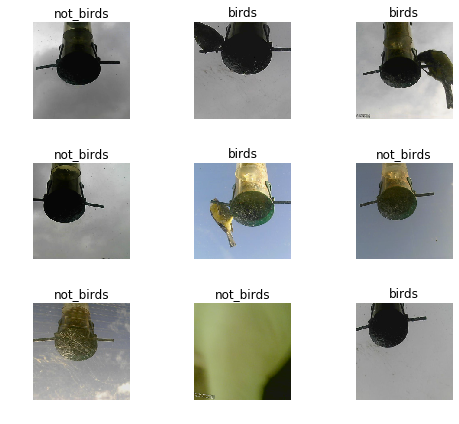

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)
len(data.classes),data.c

['birds', 'not_birds']


(2, 2)

## Training
By default fast.ai does transfer learning

In [10]:
learn = create_cnn(data, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 50887608.72it/s]


In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.621027,0.240192,0.098522
2,0.431472,0.194590,0.068966
3,0.328399,0.121956,0.039409
4,0.286995,0.116741,0.034483


Error rate down to 3.4%

Lets save the state of the model

In [12]:
learn.save('stage-1')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

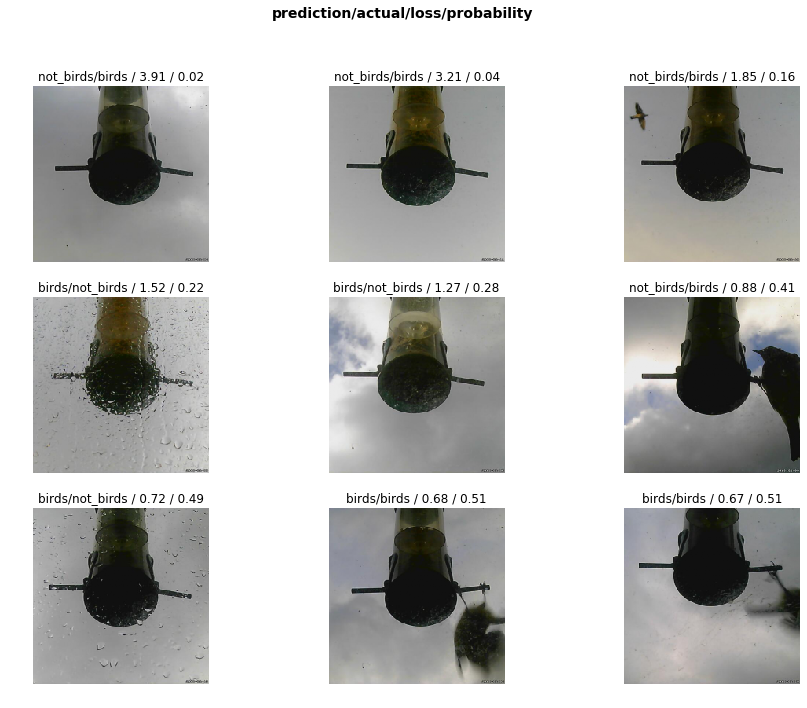

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

It appears I have a couple of incorrectly labelled images, not too surprising as I labelled them manually. Occasionally it is confusing rain for birds..?

## Unfreezing, fine-tuning, and learning rates
Lets train the whole model and see if accuracy improves..? Probably I should clean the dataset first but I am impatient

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.224294,0.217791,0.068966


Error rate up, just as in the tutorial. Lets find the best error rate

In [18]:
learn.load('stage-1');

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


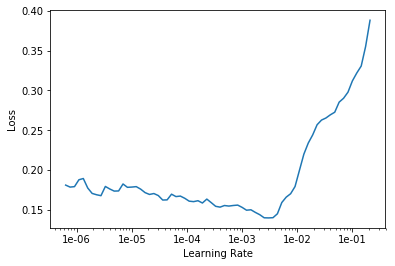

In [20]:
learn.recorder.plot()

OK the learning rates in range 1e-6,1e-3 look like a good bet

In [21]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.159831,0.123407,0.039409
2,0.156734,0.088962,0.024631


That's an improvement already!

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

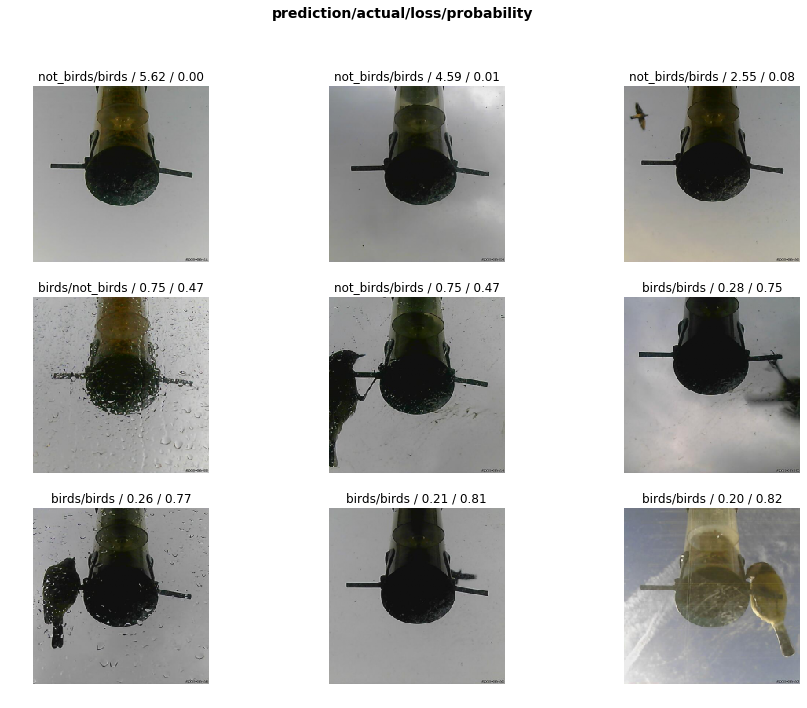

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

Not much in it. I wont waste compute on this dataset, but anyways we are doing better than classificationbox :)